In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from sklearn.metrics import jaccard_score, f1_score
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms

from EMCAD import MySegmentationDataset, PVTEMCAD

# Single GPU
device = torch.device('cuda:3')  # Using GPU 3

# # Multi GPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device_ids = list(range(torch.cuda.device_count()))

## CVC-ClinicDB

### Augmentation

In [2]:
# Augmentation function
def apply_standard_augmentations(image_list, mask_list):
    """
    Apply standard augmentations to a list of PIL images and their corresponding masks.
    Returns a list of augmented images and masks.
    """
    aug_imgs = []
    aug_masks = []
    augmentation = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
    ])
    for img, img_mask in zip(image_list, mask_list):
        seed = torch.randint(0, 2 ** 32, (1,)).item()
        torch.manual_seed(seed)
        img_aug = augmentation(img)
        torch.manual_seed(seed)
        mask_aug = augmentation(img_mask)
        aug_imgs.append(img_aug)
        aug_masks.append(mask_aug)
    return aug_imgs, aug_masks

In [3]:
# Get all image and mask paths
image_dir = 'datasets/CVC-ClinicDB/Original'
mask_dir = 'datasets/CVC-ClinicDB/Ground Truth'

image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')])
mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])

all_images = [Image.open(p).convert('RGB') for p in image_paths]
all_masks = [Image.open(p).convert('L') for p in mask_paths]

augmented_images, augmented_masks = apply_standard_augmentations(all_images, all_masks)

# Split into train and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(
    augmented_images, augmented_masks, test_size=0.2, random_state=42
)

# Create DataLoaders
train_loader = DataLoader(MySegmentationDataset(train_images, train_masks), batch_size=8, shuffle=True)
val_loader = DataLoader(MySegmentationDataset(val_images, val_masks), batch_size=8)

### Using Dice Loss

In [4]:
from torch.nn import functional

# Single GPU
model_dice = PVTEMCAD().to(device)

# # Multi GPU
# model = nn.DataParallel(PVTEMCAD().to(device), device_ids=device_ids)


def dice_loss(predictions, target, smooth=1e-6):
    probs = torch.sigmoid(predictions)
    target_unsqueezed = target
    if probs.shape != target.shape:
        target_unsqueezed = target.unsqueeze(1)
    probs = probs.view(-1)
    target_unsqueezed = target_unsqueezed.view(-1)
    intersection = (probs * target_unsqueezed).sum()

    bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([5.0], device=device))

    return 0.7 * (1 - (2. * intersection + smooth) / (probs.sum() + target.sum() + smooth)) + 0.3 * bce(predictions,
                                                                                                        target)


optimizer_dice = torch.optim.AdamW(model_dice.parameters(), lr=5e-5)
epochs = 10
for epoch in range(epochs):
    epoch_loss = 0
    num_batches = 0
    model_dice.train()
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        output = model_dice(images)
        output = functional.interpolate(output, size=masks.shape[2:], mode='bilinear', align_corners=False)

        loss = dice_loss(output, masks)
        epoch_loss += loss.item()
        num_batches += 1
        optimizer_dice.zero_grad()
        loss.backward()
        optimizer_dice.step()

    print(f"Epoch {epoch + 1}: Avg Loss = {epoch_loss / num_batches:.4f}")

Epoch 1: Avg Loss = 0.6946
Epoch 2: Avg Loss = 0.5414
Epoch 3: Avg Loss = 0.4409
Epoch 4: Avg Loss = 0.3513
Epoch 5: Avg Loss = 0.2653
Epoch 6: Avg Loss = 0.2277
Epoch 7: Avg Loss = 0.1840
Epoch 8: Avg Loss = 0.1311
Epoch 9: Avg Loss = 0.1034
Epoch 10: Avg Loss = 0.0855


### Using Unifed Focal Loss

In [5]:
def unified_focal_loss(logits, target, smooth=1e-6, gamma=2.0):
    if logits.shape != target.shape:
        target = target.unsqueeze(1)

    logits = logits.view(-1)
    target = target.view(-1)

    probs = torch.sigmoid(logits)
    intersection = (probs * target).sum()
    uni = (2. * intersection + smooth) / (probs.sum() + target.sum() + smooth)

    bce_logits = nn.BCEWithLogitsLoss(reduction='none')(logits, target)
    focal = ((1 - torch.exp(-bce_logits)) ** gamma) * bce_logits
    focal = focal.mean()

    return 0.5 * (1 - uni) + 0.5 * focal


# Single GPU
model_unified = PVTEMCAD().to(device)

# # Multi GPU
# model_unified = nn.DataParallel(PVTEMCAD().to(device), device_ids=device_ids)

optimizer_unified = torch.optim.AdamW(model_unified.parameters(), lr=5e-5)
epochs = 10
for epoch in range(epochs):
    epoch_loss = 0
    num_batches = 0
    model_unified.train()
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        output = model_unified(images)
        output = functional.interpolate(output, size=masks.shape[2:], mode='bilinear', align_corners=False)

        # loss = criterion(output, masks)
        loss = unified_focal_loss(output, masks)
        epoch_loss += loss.item()
        num_batches += 1
        optimizer_unified.zero_grad()
        loss.backward()
        optimizer_unified.step()

    print(f"Epoch {epoch + 1}: Avg Loss = {epoch_loss / num_batches:.4f}")

Epoch 1: Avg Loss = 0.4137
Epoch 2: Avg Loss = 0.3207
Epoch 3: Avg Loss = 0.2563
Epoch 4: Avg Loss = 0.1896
Epoch 5: Avg Loss = 0.1415
Epoch 6: Avg Loss = 0.1160
Epoch 7: Avg Loss = 0.0913
Epoch 8: Avg Loss = 0.0782
Epoch 9: Avg Loss = 0.0569
Epoch 10: Avg Loss = 0.0454


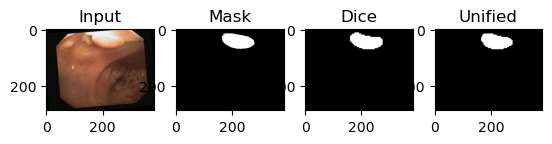

In [9]:
# Get the i-th image's prediction from the validation dataset
index = 16
image, mask = val_loader.dataset[index]
image = image.unsqueeze(0).to(device)

model_dice.eval()
with torch.no_grad():
    output_dice = torch.sigmoid(model_dice(image))
    output_dice = functional.interpolate(output_dice, size=(mask.shape[1], mask.shape[2]), mode='nearest')
    pred_dice = output_dice.cpu().squeeze().numpy()

model_unified.eval()
with torch.no_grad():
    output_unified = torch.sigmoid(model_unified(image))
    output_unified = functional.interpolate(output_unified, size=(mask.shape[1], mask.shape[2]), mode='nearest')
    pred_unified = output_unified.cpu().squeeze().numpy()

# Visualize properly
plt.subplot(1, 4, 1)
plt.imshow(image.squeeze().permute(1, 2, 0).cpu())
plt.title("Input")

plt.subplot(1, 4, 2)
plt.imshow(mask.squeeze(), cmap='gray')
plt.title("Mask")

plt.subplot(1, 4, 3)
plt.imshow(pred_dice > 0.5, cmap='gray')
plt.title("Dice")

plt.subplot(1, 4, 4)
plt.imshow(pred_unified > 0.5, cmap='gray')
plt.title("Unified")

plt.show()

In [7]:
all_preds_dice = []
all_preds_unified = []
all_targets = []

with torch.no_grad():
    for image, mask in val_loader.dataset:
        image = image.unsqueeze(0).to(device)

        out_dice = torch.sigmoid(model_dice(image))
        out_dice = functional.interpolate(out_dice, size=mask.shape[1:], mode='nearest')
        pred_dice = (out_dice.cpu().squeeze().numpy() > 0.5).astype(int).flatten()

        out_unified = torch.sigmoid(model_unified(image))
        out_unified = functional.interpolate(out_unified, size=mask.shape[1:], mode='nearest')
        pred_unified = (out_unified.cpu().squeeze().numpy() > 0.5).astype(int).flatten()

        gt = (np.array(mask) > 0.5).astype(np.uint8).flatten()

        all_preds_dice.extend(pred_dice)
        all_preds_unified.extend(pred_unified)
        all_targets.extend(gt)

# Compute once over all pixels
f1_dice = f1_score(all_targets, all_preds_dice)
iou_dice = jaccard_score(all_targets, all_preds_dice)

f1_unified = f1_score(all_targets, all_preds_unified)
iou_unified = jaccard_score(all_targets, all_preds_unified)

print(f"Dice F1: {f1_dice:.4f}, IoU: {iou_dice:.4f}")
print(f"Unified F1: {f1_unified:.4f}, IoU: {iou_unified:.4f}")

Dice F1: 0.9090, IoU: 0.8332
Unified F1: 0.9151, IoU: 0.8435


In [10]:
from ptflops import get_model_complexity_info

with device:
    macs_dice, params_dice = get_model_complexity_info(model_dice, input_res=(3, 224, 224), as_strings=True,
                                             print_per_layer_stat=False, verbose=False)
print(f"For dice, FLOPs: {macs_dice}, Params: {params_dice}")

with device:
    macs_unified, params_unified = get_model_complexity_info(model_unified, input_res=(3, 224, 224), as_strings=True,
                                             print_per_layer_stat=False, verbose=False)

print(f"For unified, FLOPs: {macs_unified}, Params: {params_unified}")

For dice, FLOPs: 5.28 GMac, Params: 29.13 M
For unified, FLOPs: 5.28 GMac, Params: 29.13 M
